In [1]:
%config AsyncShell.timeout = 300  # Increase to 300 seconds
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pandas as pd
import sklearn
import pyarrow

In [2]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

Get the size of the data set. How much memory it Takes?

In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [5]:
# Adding new feature to get the trip distance
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds / 60

In [6]:
(
    df
    [['trip_distance', 'duration']]
    .sort_values('duration', ascending=False)
    .head(10)
)
# The top 10 trips by trip_time all have extremely high values, 
# indicating likely data errors or outliers.

,trip_distance,duration
2460754,16.83,1439.800000
127500,1.55,1439.650000
271181,24.48,1439.633333
1598991,8.63,1439.616667
2359185,2.19,1439.583333
2069061,12.64,1439.466667
927194,9.73,1439.433333
1910535,3.99,1439.433333
229908,19.54,1439.383333
2881681,1.52,1439.366667


In [7]:
# number of passengers takes only one of 11 values, so it's better to convert it into category data type
len(df['passenger_count'].unique())

11

In [8]:
# How many unique values at each feature?
df.nunique().sort_values()

VendorID                       2
store_and_fwd_flag             2
congestion_surcharge           3
airport_fee                    3
improvement_surcharge          5
payment_type                   5
RatecodeID                     7
passenger_count               10
mta_tax                       10
extra                         68
PULocationID                 257
DOLocationID                 261
tolls_amount                 776
tip_amount                  4036
trip_distance               4387
fare_amount                 6873
duration                    8570
total_amount               15871
tpep_pickup_datetime     1610975
tpep_dropoff_datetime    1611319
dtype: int64

In [9]:
# get the names of columns with values less than 300 which will be converted into category
categorical_columns = (df.nunique().loc[lambda _df: _df < 300] ).index.to_list()
print(categorical_columns)
df[categorical_columns] = df[categorical_columns].astype('category')

['VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee']


In [10]:
# How much space we saved using after converting into categorical?
df.info(memory_usage='deep')
# we save more than 300MB which is more than 50% of the original size of the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        category      
 4   trip_distance          float64       
 5   RatecodeID             category      
 6   store_and_fwd_flag     category      
 7   PULocationID           category      
 8   DOLocationID           category      
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  category      
 12  mta_tax                category      
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  category      
 16  total_amount           float64       
 17  congestion_surcharge   category      
 18  airport_fee           

In [11]:
std_january_duration = df['duration'].std()
print(f"Standard deviation of trip durations in January: {std_january_duration}")

Standard deviation of trip durations in January: 41.62919110962406


In [12]:
# To remove outlier we make the duration only between 1 and 60 minutes.
df = df.query(" duration >=1 and duration <= 60")

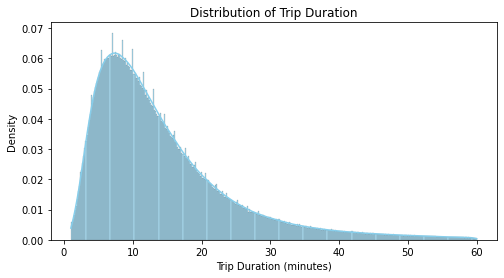

In [13]:
plt.figure(figsize=(8, 4))
sns.histplot(df['duration'], kde=True, stat='density', color='skyblue', alpha=0.7)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Density')
plt.title('Distribution of Trip Duration')
plt.show()

In [14]:
size_of_clean_df = df.shape[0]/ 3066766 * 100
print(f"The size of the data set after dropping the outlier: {size_of_clean_df:0.2f} %")

The size of the data set after dropping the outlier: 98.12 %


In [15]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)
numerical = ['trip_distance']
# We will use the DictVectorizer to convert the categorical features into a one-hot encoded format
# and the numerical features will be used as is.
# We will use the DictVectorizer to convert the categorical features into a one-hot encoded format

In [16]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

np.sqrt(mean_squared_error(y_train, y_pred))

7.649152894155631

In [ ]:
# Print the dimensionality (number of columns)
print(f"Feature matrix shape: {X_train.shape}")

In [17]:
del df, X_train, y_train, train_dicts

In [18]:
df_february  = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')
df_february['duration'] = (df_february['tpep_dropoff_datetime'] - df_february['tpep_pickup_datetime']).dt.seconds / 60
df_february = df_february.query(" duration >=1 and duration <= 60")
df_february.head()

: 

: 

: 

In [ ]:
# Exclude columns that are already categorical or datetime
categorical_columns = [
    col for col in df_february.nunique().loc[lambda _df: _df < 300].index
    if df_february[col].dtype not in ['category', 'datetime64[ns]']
]
print(categorical_columns)
df_february[categorical_columns] = df_february[categorical_columns].astype('category')

In [ ]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df_february[categorical] = df_february[categorical].astype(str)
test_dicts = df_february[categorical + numerical].to_dict(orient='records')

In [ ]:
# Test using the february as test set
dv = DictVectorizer()
X_test = dv.fit_transform(test_dicts)

target = 'duration'
y_test = df_february[target].values



y_pred = lr.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred, squared=False))